<a href="https://colab.research.google.com/github/Akash-Rayhan/Resume-Filtering-System/blob/main/notebooks/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import pickle

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/Datasets/resume_dataset/Resume/Resume.csv')
dataframe.drop(columns = ['ID', 'Resume_html'], inplace = True)
dataframe.head()

,Resume_str,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR


In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Resume_str  2484 non-null   object
 1   Category    2484 non-null   object
dtypes: object(2)
memory usage: 38.9+ KB


#### the data distribution of categories in dataset is imbalanced
#### bpo and automobile categories have below average data points

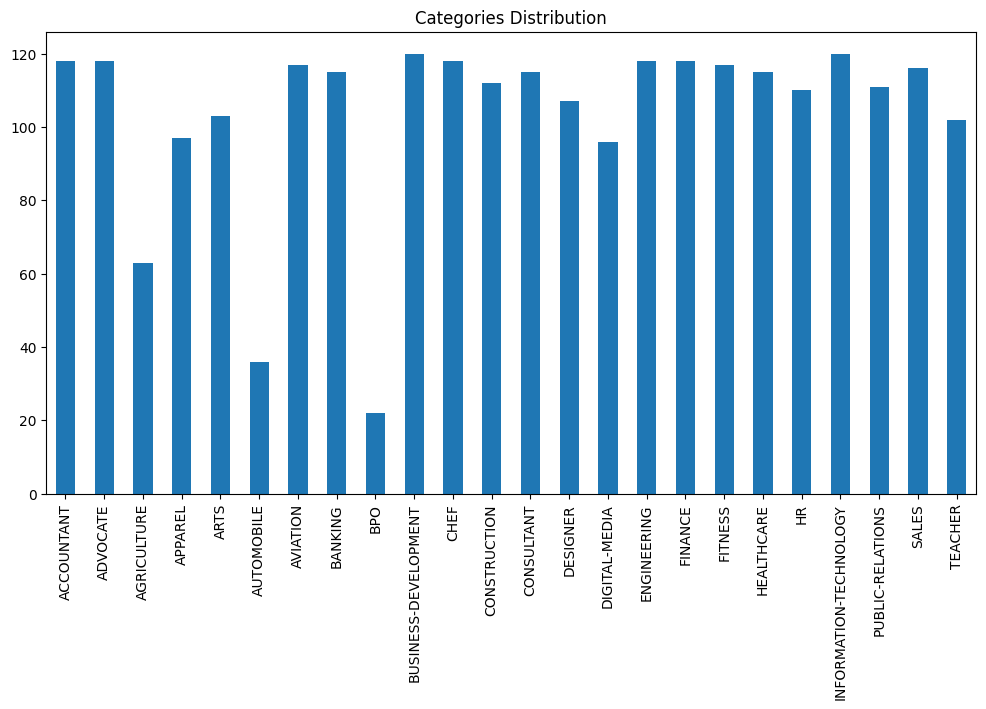

In [ ]:
dataframe['Category'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6), title='Categories Distribution')
plt.show()

# Data Preprocessing

In [ ]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    '''Make text lowercase,remove extra whitespaces, remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\s+', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('－', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Lemmatize all words in the sentence
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))

    return text

In [ ]:
dataframe['Resume_str'] = dataframe['Resume_str'].apply(preprocess_data)

In [ ]:
# label encoding the professions
le = LabelEncoder()
le.fit(dataframe['Category'])
dataframe['Category'] = le.transform(dataframe['Category'])

In [ ]:
max_token=-1 # max_token is the maximum number of tokens in any single resume
corpus = set() # As we are storing unique words, set doesnot store duplicate data

def build_corpus(text):
  """ This function creates vocabulary collecting unique words from this dataset also
  calculates numbers of words in a sentence (max_token)
  """
  global max_token
  tokens = word_tokenize(text)
  if (max_token < len(tokens)):
    max_token = len(tokens)
  for token in tokens:
    corpus.add(token)

dataframe['Resume_str'].apply(build_corpus)

0       None
1       None
2       None
3       None
4       None
        ... 
2479    None
2480    None
2481    None
2482    None
2483    None
Name: Resume_str, Length: 2484, dtype: object

In [ ]:
tokenizer = Tokenizer(num_words = len(corpus))
# Update the vocabulary list
tokenizer.fit_on_texts(corpus)

In [ ]:
features = dataframe['Resume_str'].values
targets = dataframe['Category'].values
# train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(features,targets,random_state=42, test_size=0.2,
                                                 shuffle=True, stratify=targets)

In [ ]:
# tokenizes the text data, encoding words into integers
train_sequence = tokenizer.texts_to_sequences(X_train)
test_sequence = tokenizer.texts_to_sequences(X_test)

In [ ]:
# padding ensures that shorter sequences are extended with zeros, and if necessary, longer sequences are truncated to the desired length
pad_train = pad_sequences(train_sequence, maxlen = max_token, padding = 'post', truncating = 'post' )
pad_test = pad_sequences(test_sequence, maxlen = max_token, padding = 'post', truncating = 'post' )

# Train Model

In [ ]:
def LSTM_model():
  model = Sequential()
  model.add(Embedding(input_dim = len(corpus), output_dim = 256)),
  model.add(Bidirectional(LSTM(units=128)))

  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.25))

  model.add(Dense(24, activation = 'softmax'))

  model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=['sparse_categorical_accuracy'],
  )

  return model

In [ ]:
model = LSTM_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         11522560  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              394240    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

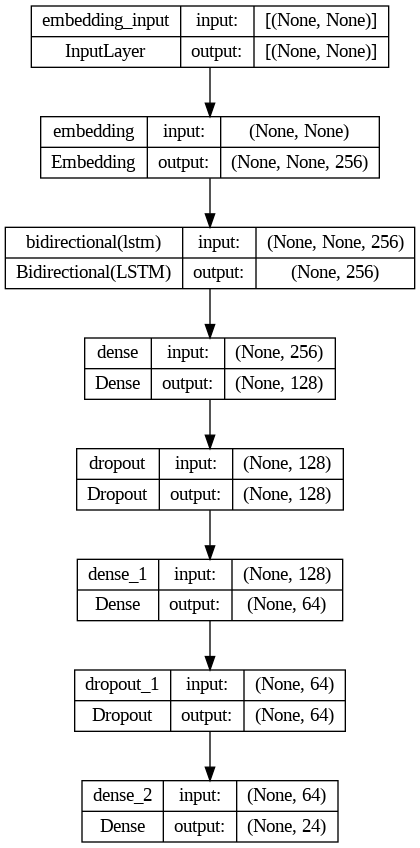

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True,random_state=2)

val_acc_per_fold = []
val_loss_per_fold = []
loss_per_fold = []
acc_per_fold = []

# K-fold Cross Validation model train & evaluation
fold_no = 1
for train, valid in kfold.split(pad_train, y_train):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(pad_train[train], y_train[train], batch_size=64,
                        epochs=2, validation_data=(pad_train[valid], y_train[valid]))
    val_acc_per_fold.append(history.history['val_sparse_categorical_accuracy'])
    acc_per_fold.append(history.history['sparse_categorical_accuracy'])
    val_loss_per_fold.append(history.history['val_loss'])
    loss_per_fold.append(history.history['loss'])
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/2
25/25 [==============================] - 26s 629ms/step - loss: 3.1571 - sparse_categorical_accuracy: 0.0617 - val_loss: 3.1217 - val_sparse_categorical_accuracy: 0.1633
Epoch 2/2
25/25 [==============================] - 13s 530ms/step - loss: 3.0313 - sparse_categorical_accuracy: 0.1605 - val_loss: 2.8525 - val_sparse_categorical_accuracy: 0.2965
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/2
25/25 [==============================] - 13s 518ms/step - loss: 2.5468 - sparse_categorical_accuracy: 0.3040 - val_loss: 2.0659 - val_sparse_categorical_accuracy: 0.4899
Epoch 2/2
25/25 [==============================] - 13s 507ms/step - loss: 1.8595 - sparse_categorical_accuracy: 0.4846 - val_loss: 1.4978 - val_sparse_categorical_accuracy: 0.5980
------------------------------------------------------------------------
Training for 

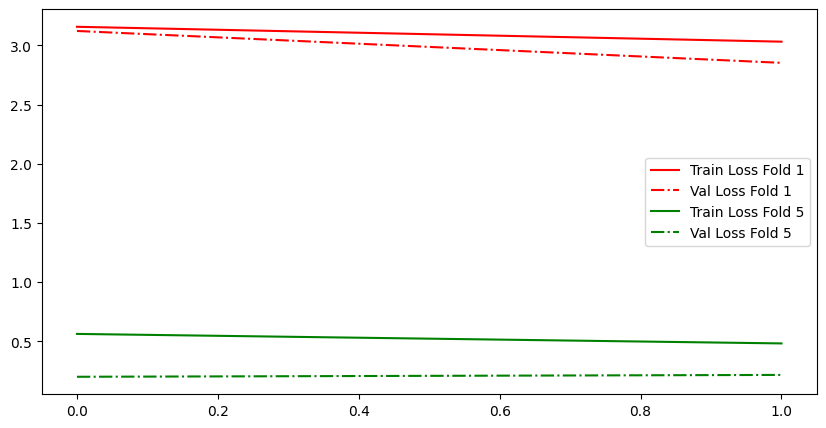

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss_per_fold[0], label='Train Loss Fold 1', color='red')
plt.plot(val_loss_per_fold[0], label='Val Loss Fold 1', color='red', linestyle = "dashdot")
plt.plot(loss_per_fold[4], label='Train Loss Fold 5', color='green')
plt.plot(val_loss_per_fold[4], label='Val Loss Fold 5', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(pad_test,y_test)

16/16 [==============================] - 2s 90ms/step - loss: 1.2614 - sparse_categorical_accuracy: 0.7042


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         11522560  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              394240    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [ ]:
predict = np.argmax(model.predict(pad_test),axis=1)
print('Test Data accuracy: ',accuracy_score(y_test, predict)*100)
print("\nConfusion Matrix : ")
cnf_matrix = confusion_matrix(y_test, predict)
print(cnf_matrix)
print("\nClassification Report :")
print(classification_report(y_test, predict, target_names=le.classes_))

16/16 [==============================] - 2s 85ms/step
Test Data accuracy:  70.4225352112676

Confusion Matrix : 
[[23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0 19  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  2  1  0  0  0  0  0]
 [ 1  1  1  1  1  0  1  0  0  0  0  1  0  0  0  0  0  0  3  0  1  2  0  0]
 [ 0  0  0  6  2  0  0  2  0  0  0  0  0  1  1  0  0  1  1  0  0  3  1  1]
 [ 0  0  1  2  7  0  0  0  0  1  0  0  0  0  1  0  1  0  0  1  0  3  1  3]
 [ 0  0  0  2  0  0  1  0  0  0  0  0  0  0  0  1  0  0  2  0  0  1  0  0]
 [ 0  0  2  8  1  0  5  2  0  0  0  1  0  0  0  1  0  1  3  0  0  0  0  0]
 [ 0  1  2  2  0  0  0 12  0  1  0  0  0  0  0  0  0  3  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  1  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  1  0  1]
 [ 0  1  0  0  0  0  1  1  0  0  0 19  0  0  0  0  0  0  0  0 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


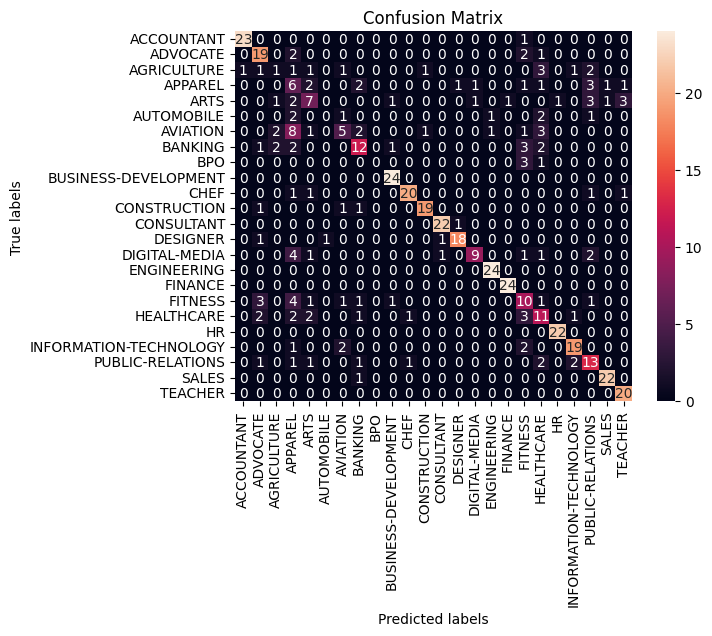

In [ ]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(le.classes_); ax.yaxis.set_ticklabels(le.classes_);

In [ ]:
model.save('/content/drive/MyDrive/Datasets/LSTM_model.keras')

In [ ]:
!pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 47.8 MB/s eta 0:00:00


In [ ]:
import fitz
doc = fitz.open("/content/drive/MyDrive/Datasets/resume_dataset/data/data/ACCOUNTANT/10554236.pdf")
text = " ".join([page.get_text() for page in doc])


content = np.array([preprocess_data(text)])

text_to_sequence = tokenizer.texts_to_sequences(content)
pad_sequence = pad_sequences(text_to_sequence, maxlen = max_token, padding = 'post')
prediction = np.argmax(model.predict(pad_sequence),axis=1)
le.inverse_transform(prediction)


1/1 [==============================] - 0s 105ms/step


array(['ACCOUNTANT'], dtype=object)

In [ ]:
pickle.dump([tokenizer,le,max_token], open("/content/drive/MyDrive/Datasets/variables.p", "wb"))